# NLP Process with Sentiment Analysis

В ноутбуке рассматривается классификация текста с использованием логистической регрессии, bag of words и tf-idf. Необходимо определить класс настроения текста. Набор данных содержит данные о просмотрах фильмов с классом настроений 0,1,2,3 и 4, где 0 - отрицательный, 1 - немного отрицательный, 2 - нейтральный, 3 - немного положительный и 4-положительный.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import ngrams
import string,re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings, os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
plt.figure(figsize=(16,7))
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

<Figure size 1600x700 with 0 Axes>

In [5]:
# Locate the data directories
for dirname, _, filenames in os.walk('/kaggle/inputcontent'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [8]:
train=pd.read_csv('/content/train.tsv.zip',sep='\t')
test=pd.read_csv('/content/test.tsv.zip',sep='\t')

In [9]:
train.shape, test.shape

((156060, 4), (66292, 3))

In [10]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [12]:
train.isnull().sum()

,0
PhraseId,0
SentenceId,0
Phrase,0
Sentiment,0


In [13]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [14]:
train['sentiment_class'] = train['Sentiment'].map({0:'negative',1:'somewhat negative',2:'neutral',3:'somewhat positive',4:'positive'})
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [61]:
def remove_punctuation(text):
  text = str(text)
  return "".join([t for t in text if t not in string.punctuation])

In [16]:
train['Phrase']=train['Phrase'].apply(lambda x:remove_punctuation(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [17]:
def words_with_more_than_three_chars(text):
    return " ".join([t for t in text.split() if len(t)>3])

In [18]:
train['Phrase']=train['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage that what...,1,somewhat negative
1,2,1,series escapades demonstrating adage that what...,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


In [22]:
stop_words=stopwords.words('english')
train['Phrase']=train['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative
1,2,1,series escapades demonstrating adage good goose,2,neutral
2,3,1,series,2,neutral
3,4,1,,2,neutral
4,5,1,series,2,neutral


In [23]:
train.groupby('Sentiment')['Sentiment'].count()

,Sentiment
Sentiment,
0,7072
1,27273
2,79582
3,32927
4,9206


<Axes: title={'center': 'Target class'}, xlabel='sentiment_class'>

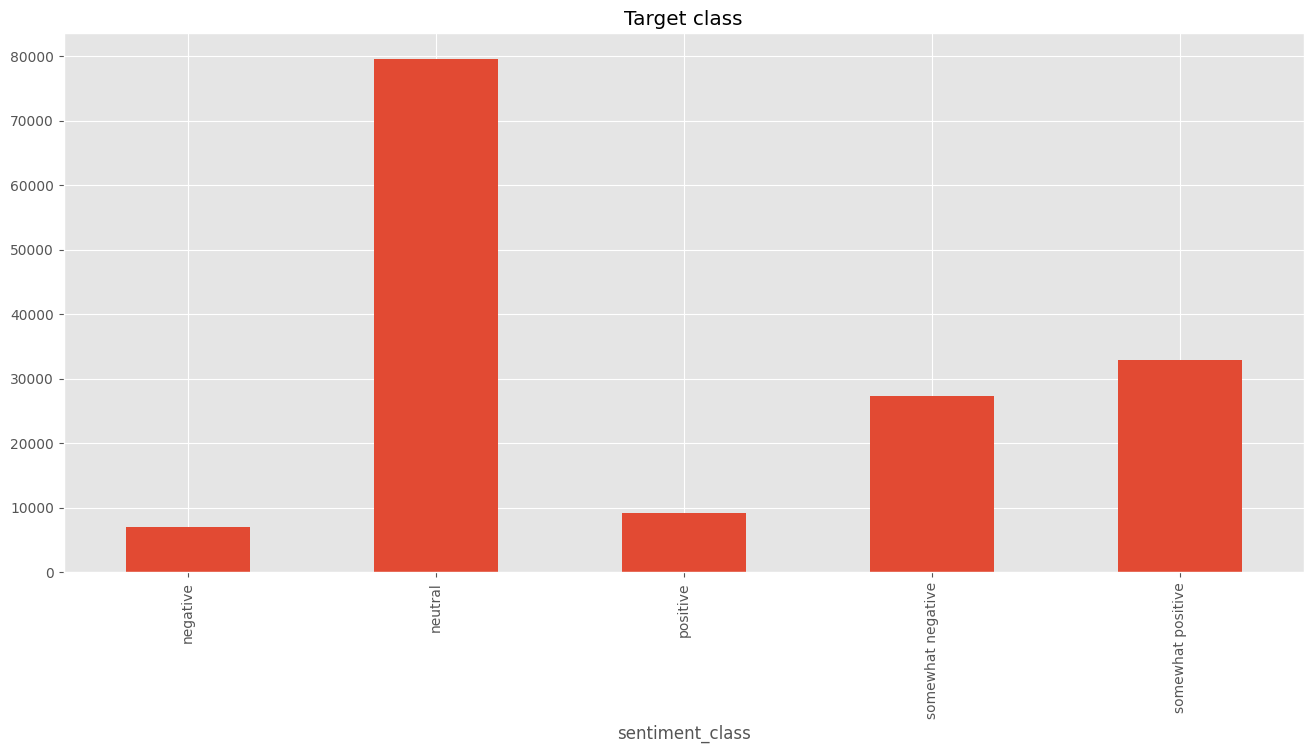

In [24]:
train.groupby('sentiment_class')['sentiment_class'].count().plot(kind='bar',title='Target class',figsize=(16,7),grid=True)

<Axes: title={'center': '% Target class'}, ylabel='sentiment_class'>

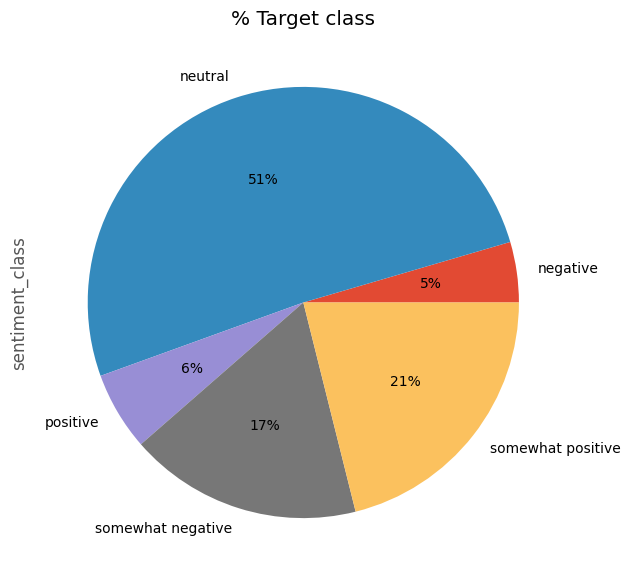

In [25]:
((train.groupby('sentiment_class')['sentiment_class'].count()/train.shape[0])*100).plot(kind='pie',figsize=(7,7),title='% Target class', autopct='%1.0f%%')

In [26]:
train['PhraseLength']=train['Phrase'].apply(lambda x: len(x))

In [27]:
train.sort_values(by='PhraseLength', ascending=False).head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength
54876,54877,2734,Filmmakers Dana JanklowiczMann Amir Mann area ...,3,somewhat positive,207
62992,62993,3189,addition sporting worst titles recent cinemati...,0,negative,200
26148,26149,1199,movie biggest shocks come seeing former nymphe...,1,somewhat negative,199
62500,62501,3162,While transgressive trappings especially frank...,1,somewhat negative,197
72577,72578,3708,Stephen Earnhart documentary decomposition hea...,1,somewhat negative,196


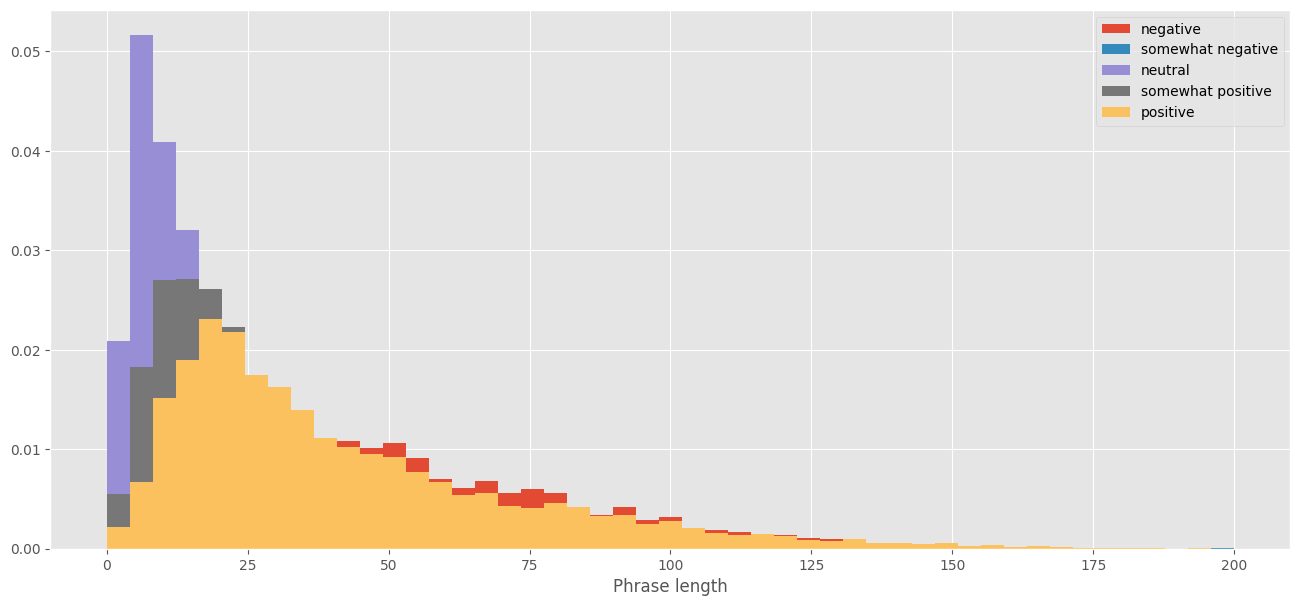

In [28]:
plt.figure(figsize=(16,7))
bins=np.linspace(0,200,50)
plt.hist(train[train['sentiment_class']=='negative']['PhraseLength'],bins=bins,density=True,label='negative')
plt.hist(train[train['sentiment_class']=='somewhat negative']['PhraseLength'],bins=bins,density=True,label='somewhat negative')
plt.hist(train[train['sentiment_class']=='neutral']['PhraseLength'],bins=bins,density=True,label='neutral')
plt.hist(train[train['sentiment_class']=='somewhat positive']['PhraseLength'],bins=bins,density=True,label='somewhat positive')
plt.hist(train[train['sentiment_class']=='positive']['PhraseLength'],bins=bins,density=True,label='positive')
plt.xlabel('Phrase length')
plt.legend()
plt.show()


In [29]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

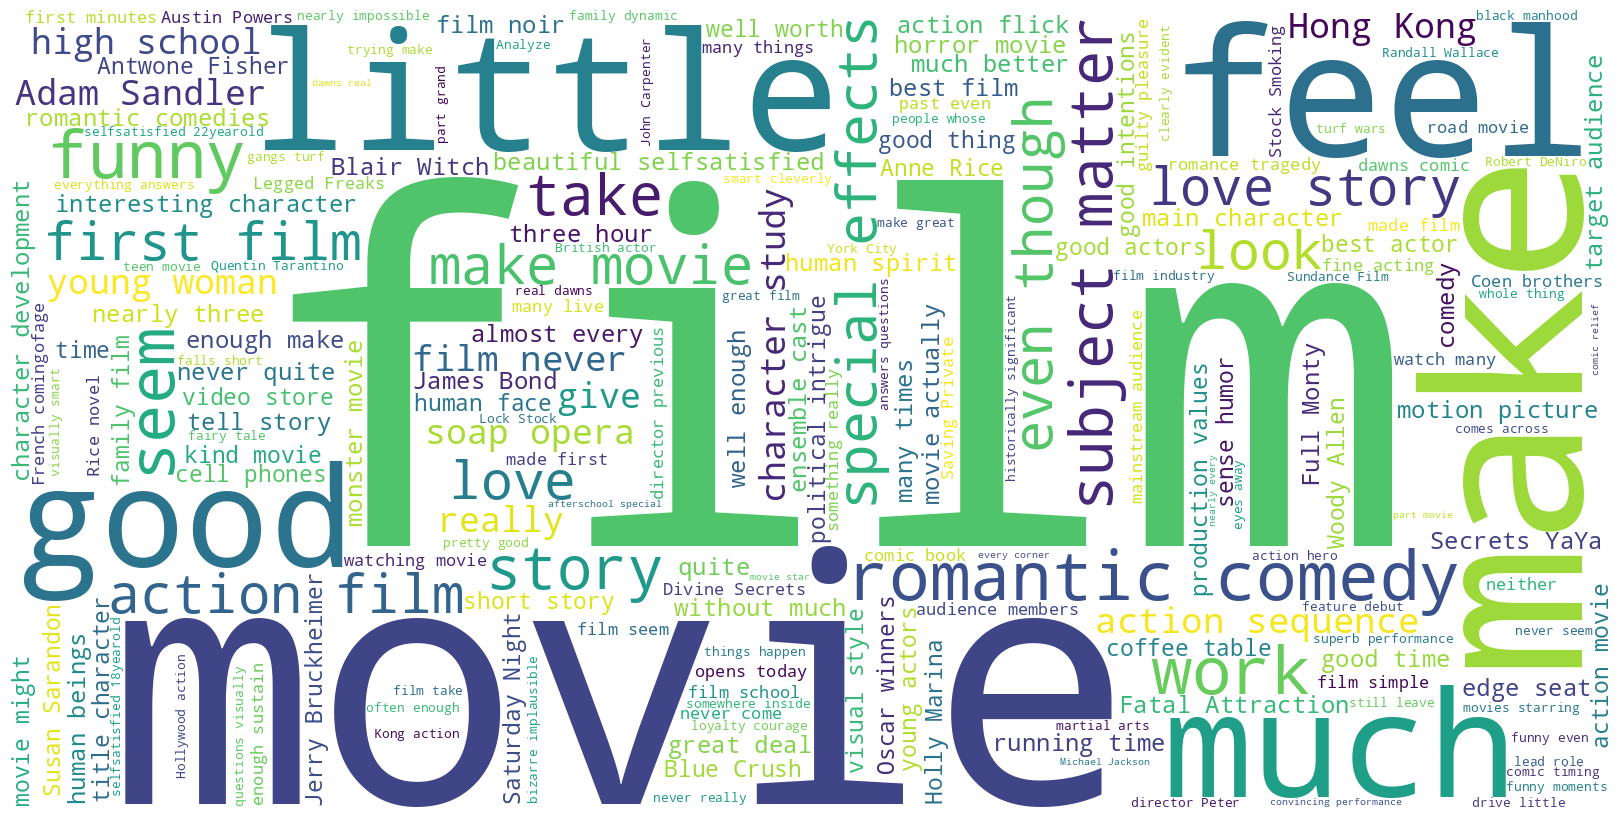

In [30]:
word_cloud_common_words=[]
for index, row in train.iterrows():
    word_cloud_common_words.append((row['Phrase']))
word_cloud_common_words

wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5).generate(''.join(word_cloud_common_words))

# plot the WordCloud image
plt.figure(figsize = (16, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [33]:
text_list=[]
for index, row in train.iterrows():
    text_list.append((row['Phrase']))
text_list

total_words=''.join(text_list)
total_words=word_tokenize(total_words)

In [34]:
freq_words=FreqDist(total_words)
word_frequency=FreqDist(freq_words)

In [35]:
# 10 common words
print(word_frequency.most_common(10))

[('film', 3259), ('movie', 2892), ('like', 1968), ('story', 1204), ('much', 1085), ('good', 1069), ('even', 1041), ('characters', 994), ('little', 976), ('make', 838)]


<Axes: >

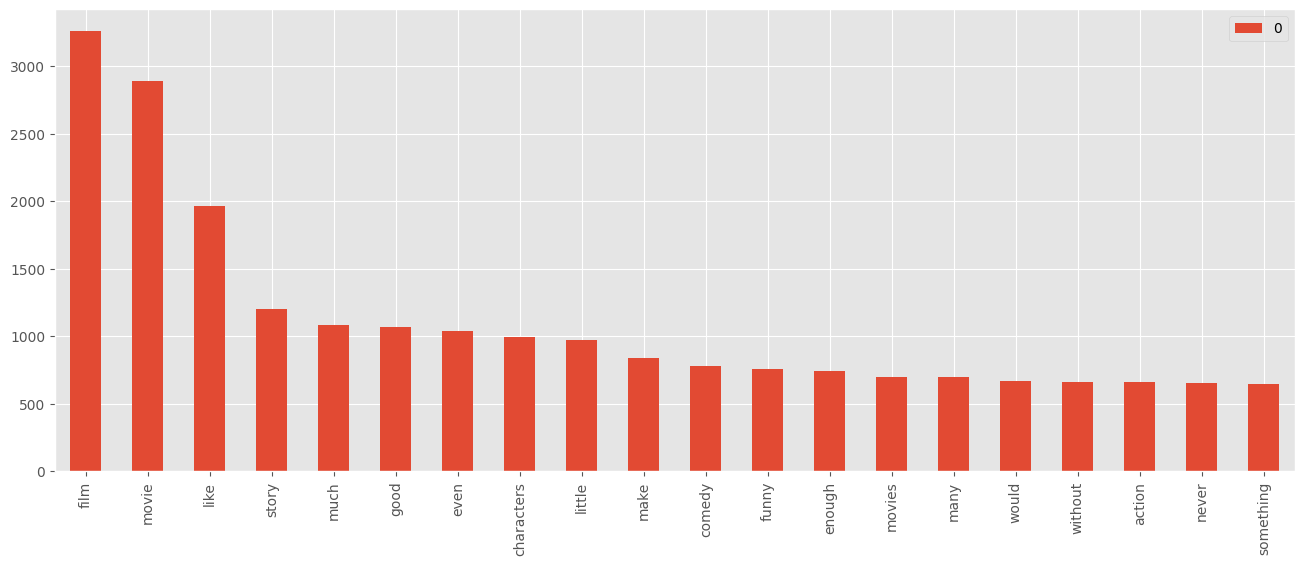

In [36]:
# visualize
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

In [37]:
neg_text_list=[]
for index, row in train[train['Sentiment']==0].iterrows():
    neg_text_list.append((row['Phrase']))
neg_text_list

neg_total_words=' '.join(neg_text_list)
neg_total_words=word_tokenize(neg_total_words)

neg_freq_words=FreqDist(neg_total_words)
neg_word_frequency=FreqDist(neg_freq_words)

<Axes: >

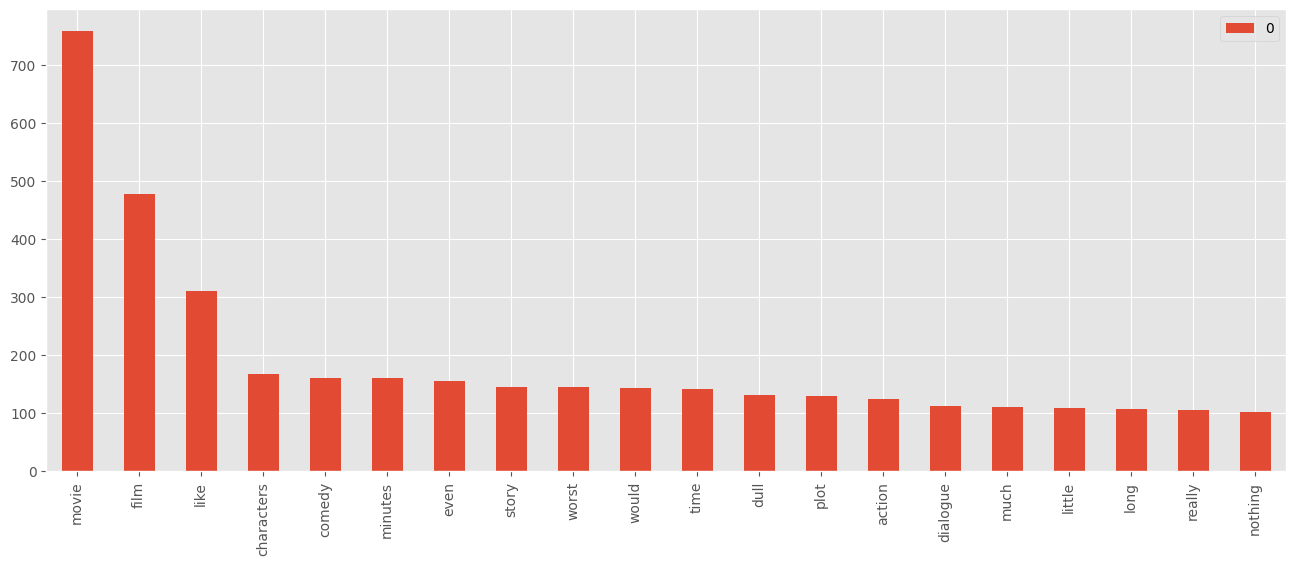

In [38]:
# visualize
pd.DataFrame(neg_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

In [39]:
pos_text_list=[]
for index, row in train[train['Sentiment']==4].iterrows():
    pos_text_list.append((row['Phrase']))
pos_text_list

pos_total_words=' '.join(pos_text_list)
pos_total_words=word_tokenize(pos_total_words)

pos_freq_words=FreqDist(pos_total_words)
pos_word_frequency=FreqDist(pos_freq_words)

<Axes: >

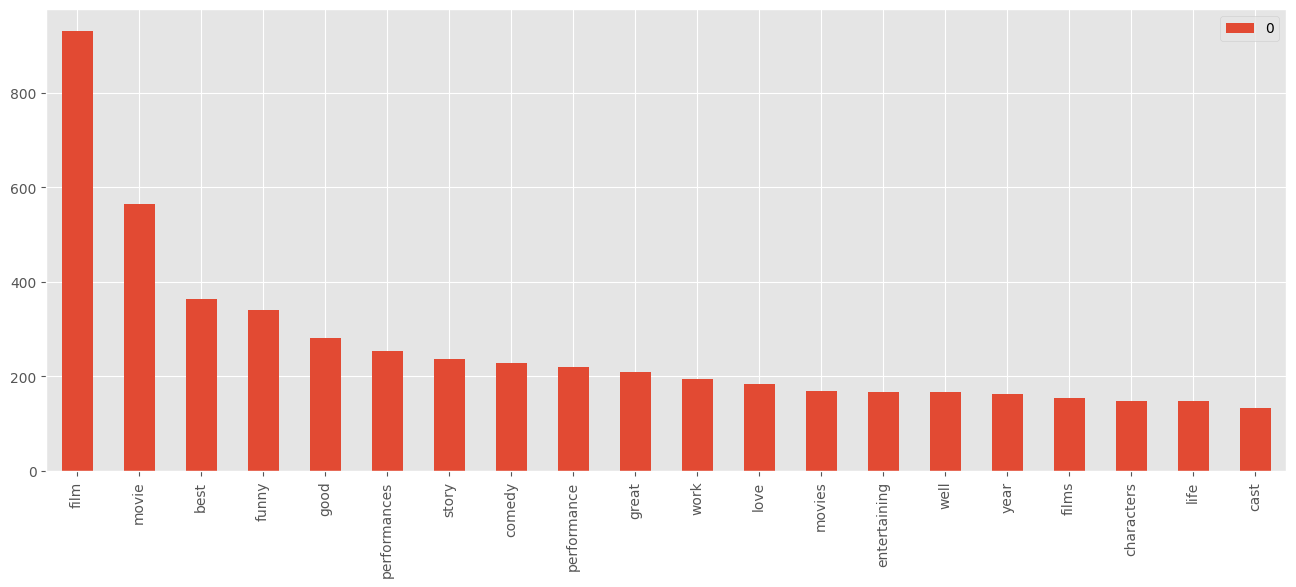

In [40]:
# visualize
pd.DataFrame(pos_word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

In [41]:
text="Tom and Jerry love mickey. But mickey dont love Tom and Jerry. What a love mickey is getting from these two friends"
bigram_frequency = FreqDist(ngrams(word_tokenize(text),3))
bigram_frequency.most_common()[0:5]

[(('Tom', 'and', 'Jerry'), 2),
 (('and', 'Jerry', 'love'), 1),
 (('Jerry', 'love', 'mickey'), 1),
 (('love', 'mickey', '.'), 1),
 (('mickey', '.', 'But'), 1)]

In [42]:
text_list=[]
for index, row in train.iterrows():
    text_list.append((row['Phrase']))
text_list

total_words=' '.join(text_list)
total_words=word_tokenize(total_words)

freq_words=FreqDist(total_words)
word_frequency=FreqDist(ngrams(freq_words,2))
word_frequency.most_common()[0:5]

[(('film', 'movie'), 1),
 (('movie', 'like'), 1),
 (('like', 'story'), 1),
 (('story', 'good'), 1),
 (('good', 'characters'), 1)]

<Axes: >

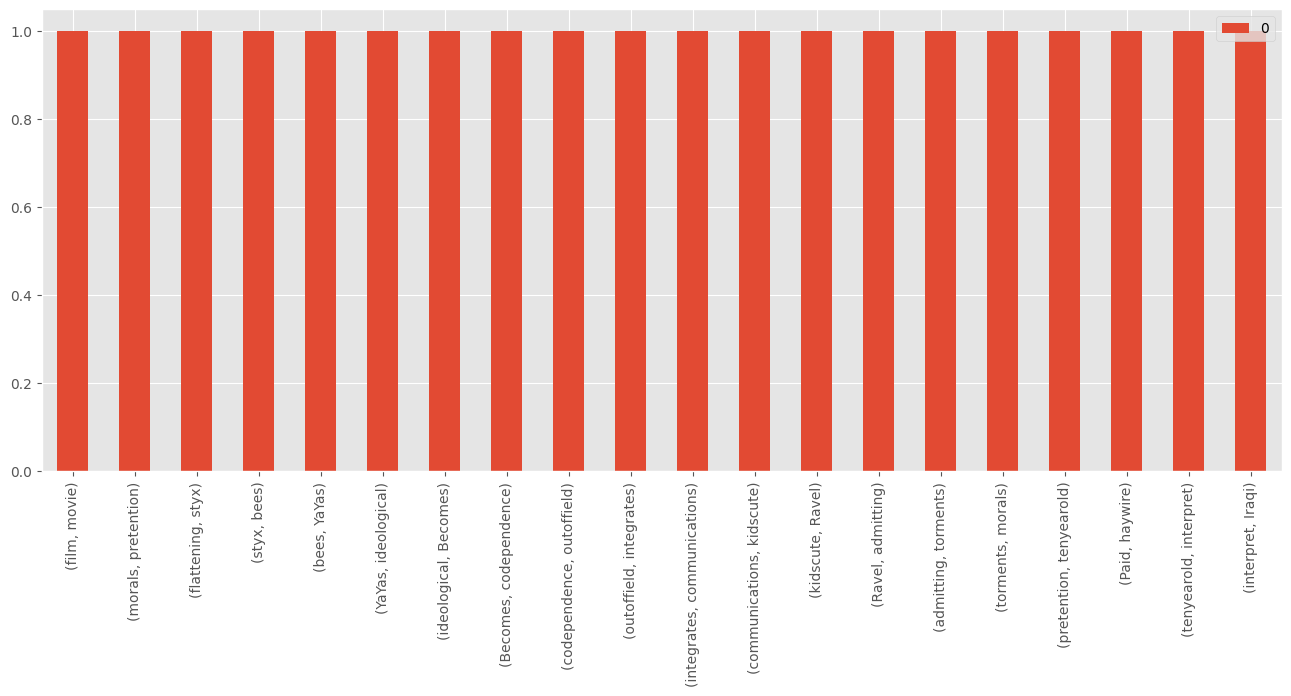

In [43]:
# visualize
pd.DataFrame(word_frequency,index=[0]).T.sort_values(by=[0],ascending=False).head(20).plot(kind='bar',figsize=(16,6),grid=True)

In [44]:
train['tokenized_words']=train['Phrase'].apply(lambda x:word_tokenize(x))
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,sentiment_class,PhraseLength,tokenized_words
0,1,1,series escapades demonstrating adage good goos...,1,somewhat negative,108,"[series, escapades, demonstrating, adage, good..."
1,2,1,series escapades demonstrating adage good goose,2,neutral,47,"[series, escapades, demonstrating, adage, good..."
2,3,1,series,2,neutral,6,[series]
3,4,1,,2,neutral,0,[]
4,5,1,series,2,neutral,6,[series]


In [45]:
count_vectorizer=CountVectorizer()
phrase_dtm=count_vectorizer.fit_transform(train['Phrase'])

In [46]:
phrase_dtm.shape

(156060, 15746)

In [47]:
X_train,X_val,y_train,y_val=train_test_split(phrase_dtm,train['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

In [48]:
model=LogisticRegression()

In [49]:
model.fit(X_train,y_train)

LogisticRegression()

In [50]:
accuracy_score(model.predict(X_val),y_val)*100

63.76180101670298

In [51]:
del X_train
del X_val
del y_train
del y_val

In [52]:
tfidf=TfidfVectorizer()
tfidf_dtm=tfidf.fit_transform(train['Phrase'])

In [53]:
X_train,X_val,y_train,y_val=train_test_split(tfidf_dtm,train['Sentiment'],test_size=0.3, random_state=38)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((109242, 15746), (109242,), (46818, 15746), (46818,))

In [54]:
tfidf_model=LogisticRegression()

In [55]:
tfidf_model.fit(X_train,y_train)

LogisticRegression()

In [56]:
accuracy_score(tfidf_model.predict(X_val),y_val)*100

62.189756076722624

In [57]:
print(tfidf_model.predict(X_val)[0:10])

[3 2 2 2 3 2 2 3 2 3]


In [58]:
def predict_new_text(text):
    tfidf_text=tfidf.transform([text])
    return tfidf_model.predict(tfidf_text)

In [59]:
predict_new_text("The movie is bad and sucks!")

array([0])

In [62]:
test['Phrase']=test['Phrase'].apply(lambda x:remove_punctuation(x))
test['Phrase']=test['Phrase'].apply(lambda x:words_with_more_than_three_chars(x))
test['Phrase']=test['Phrase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_dtm=tfidf.transform(test['Phrase'])

In [63]:
# Predict with test data
test['Sentiment']=tfidf_model.predict(test_dtm)
test.set_index=test['PhraseId']
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,intermittently pleasing mostly routine effort,3
1,156062,8545,intermittently pleasing mostly routine effort,3
2,156063,8545,,2
3,156064,8545,intermittently pleasing mostly routine effort,3
4,156065,8545,intermittently pleasing mostly routine,3
